# MicroGrad From Scratch
- Reference: [The spelled-out intro to neural networks and backpropagation: building micrograd](https://youtu.be/VMj-3S1tku0?si=y44PfR_wyXdGX21w)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x+5

In [ ]:
f(3)

20

In [ ]:
xs = np.arange(-5,5,0.25)

In [ ]:
ys = f(xs)

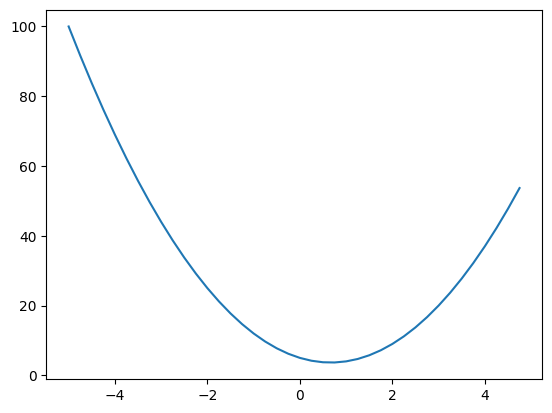

In [ ]:
plt.plot(xs,ys)

In [ ]:
h = 0.001
x = 2/3
(f(x+h) - f(x))/h

0.0029999999995311555

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [ ]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b+=h
d2 = a*b+c


print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self.grad = 0

    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data},label={self.label})"
  def __add__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data,_children=(self,other),_op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data * other.data,_children=(self,other),_op='*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out
  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __rmul__(self,other):
    return self * other
  def __radd__(self, other): # other + self
    return self + other
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
      # other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0,label='f')
L = d * f; L.label='L'
L

Value(data=-8.0,label=L)

In [ ]:
d._prev

{Value(data=-6.0,label=e), Value(data=10.0,label=c)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


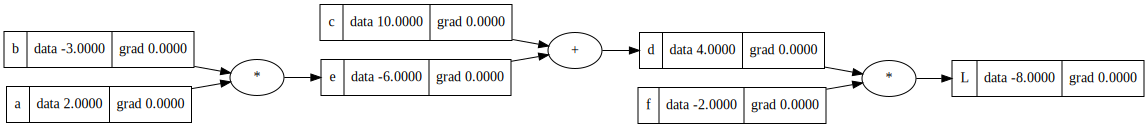

In [ ]:
draw_dot(L)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
o.grad = 1

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()
x2w2._backward()

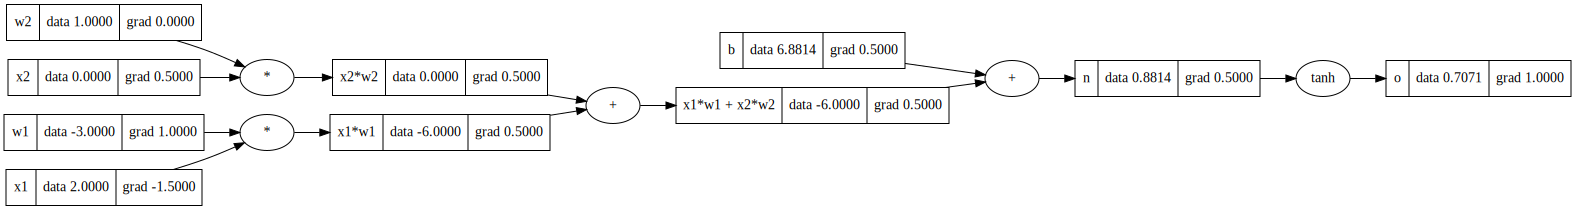

In [ ]:
draw_dot(o)

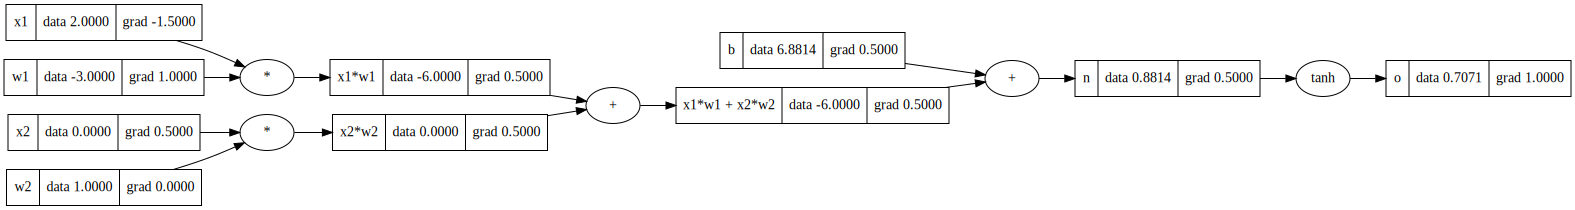

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# o.grad = 1
o.backward()
draw_dot(o)

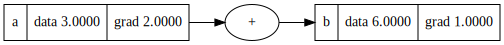

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

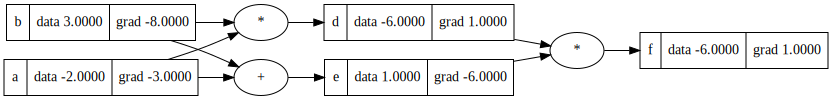

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [ ]:
a = Value(2.0)
a*2

Value(data=4.0,label=)

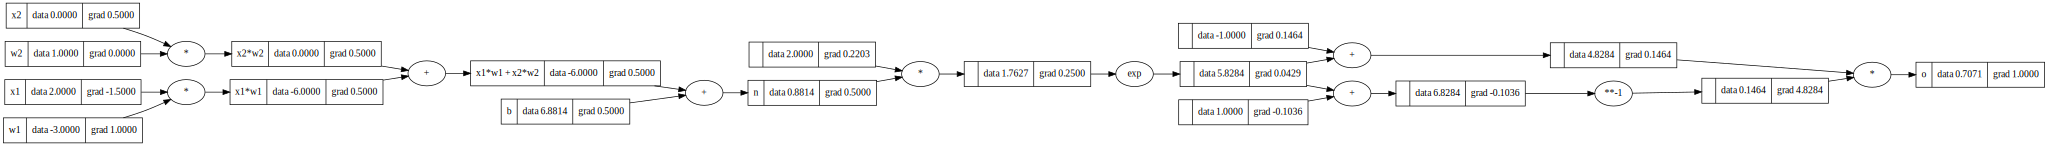

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
o = (e - 1) / (e + 1)

In [ ]:
z = (e - 1)
d = (e + 1)
z / d

Value(data=0.7071067811865477,label=)

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def parameters(self):
    return self.w + [self.b]

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    all_layer_params = []
    for neuron in self.neurons:
      all_layer_params.extend(neuron.parameters())
    return all_layer_params

    # return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    for y in range(len(nouts)):
      print(f'Forming Layer: {sz[y]} {sz[y+1]}')
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      # print(x)
      x = layer(x)
    return x

  def parameters(self):
    all_layers_params = []
    for layer in self.layers:
      all_layers_params.extend(layer.parameters())
    return all_layers_params

In [ ]:
# x = [2.0, 3.0, -1.0,2.0,4.0]
# n = MLP(5, [9, 9,3, 1])
# n(x)

Forming Layer: 5 9
Forming Layer: 9 9
Forming Layer: 9 3
Forming Layer: 3 1


Value(data=-0.03886340232667922,label=)

In [ ]:
# n.layers[3].neurons

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]

In [ ]:
computed_difference = []
for ys_item, ypred_item in zip(ys,ypred):
  computed_difference.append((ypred_item - ys_item)**2)
loss = sum(computed_difference)

In [ ]:
loss.backward()

In [ ]:
draw_dot(loss)

In [ ]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
for k in range(50):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # zero grad
  for p in n.parameters():
    p.grad = 0.0
   # backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += 0.001 * p.grad

  print(k, loss.data)


0 0.003993277217827659
1 0.00399373689433724
2 0.00399419667404062
3 0.0039946565569720744
4 0.003995116543165937
5 0.003995576632656536
6 0.003996036825478251
7 0.00399649712166541
8 0.0039969575212523934
9 0.003997418024273612
10 0.003997878630763445
11 0.0039983393407563616
12 0.0039988001542867885
13 0.003999261071389149
14 0.003999722092097953
15 0.004000183216447685
16 0.0040006444444728355
17 0.004001105776207876
18 0.004001567211687394
19 0.004002028750945946
20 0.004002490394018043
21 0.004002952140938303
22 0.004003413991741295
23 0.004003875946461637
24 0.00400433800513392
25 0.004004800167792832
26 0.0040052624344729905
27 0.004005724805209092
28 0.004006187280035797
29 0.004006649858987796
30 0.004007112542099832
31 0.004007575329406604
32 0.004008038220942898
33 0.004008501216743459
34 0.004008964316843007
35 0.0040094275212764
36 0.004009890830078411
37 0.004010354243283892
38 0.004010817760927641
39 0.0040112813830445355
40 0.0040117451096694364
41 0.004012208940837216


In [ ]:
ypred

[Value(data=0.9687346996350586,label=),
 Value(data=-0.9691864776564217,label=),
 Value(data=-0.9694490043651001,label=),
 Value(data=0.9660063556307552,label=)]

In [ ]:
# trophy pictures
SHOW_REWARDS = False
if SHOW_REWARDS:
  draw_dot(loss).render('loss_graph', format='png', view=False)
  draw_dot(n(x)).render('neural_network_graph', format='png', view=False)